In [2]:
##import necessary modules
import matplotlib.pyplot as plt
import numpy as np
import scipy
import random
from osgeo import gdal, gdalconst
from rasterio.plot import show
from skimage.feature import graycomatrix, graycoprops
from skimage.measure import shannon_entropy
from skimage.color import rgb2gray
from skimage.morphology import reconstruction
from skimage.morphology import erosion
from skimage.morphology import disk
from skimage import util
from numpy import savetxt
from numpy import loadtxt
import earthpy.spatial as es
import earthpy.plot as ep

In [3]:
#full imagery
asi = 'Input/Imagery/SingleDateImage_Amsterdam.tif'
ami = 'Input/Imagery/MedianImage_Amsterdam.tif'
msi = 'Input/Imagery/SingleDateImage_Milano.tif'
mmi = 'Input/Imagery/MedianImage_Milano.tif'
bsi = 'Input/Imagery/SingleDateImage_Budapest.tif'
bmi = 'Input/Imagery/MedianImage_Budapest.tif'
filist = [asi, ami, msi, mmi, bsi, bmi]
#Subsets
asisub = 'Input/Imagery/Subset_SingleDateImage_Amsterdam.tif'
amisub = 'Input/Imagery/Subset_MedianImage_Amsterdam.tif'
msisub = 'Input/Imagery/Subset_SingleDateImage_Milano.tif'
mmisub = 'Input/Imagery/Subset_MedianImage_Milano.tif'
bsisub = 'Input/Imagery/Subset_SingleDateImage_Budapest.tif'
bmisub = 'Input/Imagery/Subset_MedianImage_Budapest.tif'
sublist = [asisub, amisub, msisub, mmisub, bsisub, bmisub]
##Extracted features
#empasi = load('Output/empasi.npy')
#glcmasi = load('Output/glcmasi.npy')
#empmsi = load('Output/empmsi.npy')
#glcmmsi = load('Output/glcmmsi.npy')
#empbsi = load('Output/empbsi.npy')
#glcmbsi = load('Output/glcmbsi.npy')
##Twitter
atwitter = 'Imagery/TwitterRaster/TwitterRaster_Amsterdam.tif'
mtwitter = 'Imagery/TwitterRaster/Budapest_Twitter_Raster.tif'
btwitter = 'Imagery/TwitterRaster/Milano_Twitter_Raster.tif'
atwittersub = 'Imagery/TwitterRaster/Subset_TwitterRaster_Amsterdam.tif' 
mtwittersub = 'Imagery/TwitterRaster/Subset_TwitterRaster_Milano.tif'
btwittersub = 'Imagery/TwitterRaster/Subset_TwitterRaster_Budapest.tif'
##validation datasets
avalsub = 'Imagery/ValidationRaster/Subset_Validation_30m_Amsterdam.tif'
mvalsub = 'Imagery/ValidationRaster/Subset_Validation_30m_Milano.tif'
bvalsub = 'Imagery/ValidationRaster/Subset_Validation_30m_Budapest.tif'

In [4]:
def read_data_NDWI(inraster):
    def convert(img_g, target_type_min, target_type_max, target_type):
        imin = np.amin(img_g)
        imax = np.amax(img_g)
        a = (target_type_max - target_type_min) / (imax - imin)
        b = target_type_max - a * imax
        new_img = (a * img_g + b).astype(target_type)
        return new_img
    
    img = gdal.Open(inraster, gdal.GA_ReadOnly) 
    bands = [img.GetRasterBand(i).ReadAsArray() for i in range(1, img.RasterCount + 1)]
    img = np.array(bands)
    img = img[0:12,:,:]
    img = np.transpose(img, [1, 2, 0])
    imgblue = img[:,:,[1]]
    imgblue = imgblue[:, :, 0]
    imggreen = img[:,:,[2]]
    imggreen = imggreen[:, :, 0]
    imgred = img[:,:,[3]]
    imgred = imgred[:, :, 0]
    imgnir = img[:,:,[7]]
    imgnir = imgnir[:, :, 0]
    img_rgb = img[:,:,[3,2,1]]
    blueband = convert(imgblue, 0, 256, np.uint8)
    greenband = convert(imggreen, 0, 256, np.uint8)
    redband = convert(imgred, 0, 256, np.uint8)
    nirband = convert(imgnir, 0, 256, np.uint8)
    return imgblue, imggreen, imgred, imgnir

def MyNormalize(img_i,sigma):
        nr,nc,nb = img_i.shape
        img_n = np.zeros(shape=(nr,nc,nb))
        for i in range(0,nb):
            one_band = img_i[:,:,i]
            mi = np.min(one_band)
            ma = np.max(one_band)
            one_band = (one_band-mi)/(ma-mi+np.finfo(float).eps)
            img_n[:,:,i] = sigma*one_band
        return img_n

In [5]:
%%time
#https://github.com/berkesenturk/Remote-Sensing-Sentinel-2-EO-Data-Masking-Algorithm/blob/main/utils.py

NDWIlist = {}
x = 0
for img in sublist:
    x += 1
    blueband, green_band, redband, nir_band = read_data_NDWI(img)
    np.seterr(divide='ignore', invalid='ignore')
    ndwi = (nir_band - green_band) / (nir_band + green_band)
    ndwi= np.nan_to_num(ndwi)
    NDWIlist[x] = ndwi

Wall time: 70.8 ms


In [6]:
#save NDVI
ndwiasi = np.savetxt('ndwiasi.csv', NDWIlist[1], delimiter=',')
ndwiami = np.savetxt('ndwiami.csv', NDWIlist[2], delimiter=',')
ndwimsi = np.savetxt('ndwimsi.csv', NDWIlist[3], delimiter=',')
ndwimmi = np.savetxt('ndwimmi.csv', NDWIlist[4], delimiter=',')
ndwibsi = np.savetxt('ndwibsi.csv', NDWIlist[5], delimiter=',')
ndwibmi = np.savetxt('ndwibmi.csv', NDWIlist[6], delimiter=',')

In [8]:
#load NDVI
ndwiasi = loadtxt('FeatureExtraction/ndwiasi.csv', delimiter=',')
ndwiami = loadtxt('FeatureExtraction/ndwiami.csv', delimiter=',')
ndwimsi = loadtxt('FeatureExtraction/ndwimsi.csv', delimiter=',')
ndwimmi = loadtxt('FeatureExtraction/ndwimmi.csv', delimiter=',')
ndwibsi = loadtxt('FeatureExtraction/ndwibsi.csv', delimiter=',')
ndwibmi = loadtxt('FeatureExtraction/ndwibmi.csv', delimiter=',')

ndwi_list = [ndwiasi, ndwiami, ndwimsi, ndwimmi, ndwibsi, ndwibmi]

In [10]:
import math 
#Random pixel from witterraster
'''
call function:
image = read_twitter(inputraster)
plot = plt.imshow(image)
'''
def read_twitter(inras):
    twitter = gdal.Open(inras, gdal.GA_ReadOnly)
    band = twitter.GetRasterBand(1).ReadAsArray()
    twitter = np.array(band)
    return twitter

#Random pixel from Validationraster
'''
call function:
image = read_validation(inputraster)
plot = plt.imshow(image)
'''
def read_validation(inras):
    validation = gdal.Open(inras, gdal.GA_ReadOnly)
    band = validation.GetRasterBand(1).ReadAsArray()
    validation = np.array(band)
    return validation

##get row/column for twitter cells
image = read_twitter(atwittersub)
Twitterpoints = np.where(image>0)
listoftwitter= list(zip(Twitterpoints[0], Twitterpoints[1]))
sampletwitter = random.sample(listoftwitter, 50)

##get row/column for pervious cells
imageval = read_validation(avalsub)
impervious = np.where(imageval==2)
pervious = np.where(imageval==1)
perviouslist = list(zip(pervious[0], pervious[1]))
imperviouslist = list(zip(impervious[0], impervious[1]))
listofmatches = [x for x in listoftwitter if x in perviouslist] #some twitter pixels overlap with 'pervious' label in validationraster
listofpervious = [] 
for tuple in perviouslist:
    if tuple not in listofmatches:
        listofpervious.append(tuple)
samplepervious = random.sample(listofpervious, 1000)
sampleimpervious = random.sample(imperviouslist, 1000)

print('image: ' + str(sublist[1]))
print('Number of pervious pixels in image: ' + str(len(perviouslist)))
print('Number of impervious pixels in image: ' + str(len(imperviouslist)))
print('Number of Twitter pixels in image: ' + str(len(listoftwitter)))
#print('Random sample of Twitter coordinates (row/col): ' + str(sampletwitter))
#print('Random sample of Pervious coordinates (row/col): ' + str(samplepervious))

image: Imagery/SatelliteImagery/Subset_MedianImage_Amsterdam.tif
Number of pervious pixels in image: 17766
Number of impervious pixels in image: 22635
Number of Twitter pixels in image: 51


In [11]:
#print(sampletwitter)
#print(samplepervious)
#print(ndwi_list[1].shape)

ndwi_twitter = []
ndwi_pervious = []
indexlist = list(range(0, 1000))
for i in indexlist:
    coordinate = sampleimpervious[i]
    coordinate = list(coordinate)
    row = coordinate[0]
    column = coordinate[1]
    ndwi_twitter.append(ndwiasi[row][column])

for i in indexlist:
    coordinate = samplepervious[i]
    coordinate = list(coordinate)
    row = coordinate[0]
    column = coordinate[1]
    ndwi_pervious.append(ndwiasi[row][column])
        
for i, n in enumerate(ndwi_twitter):
    if n > 1:
        ndwi_twitter[i] = 1

for i, n in enumerate(ndwi_pervious):
    if n > 1:
        ndwi_pervious[i] = 1

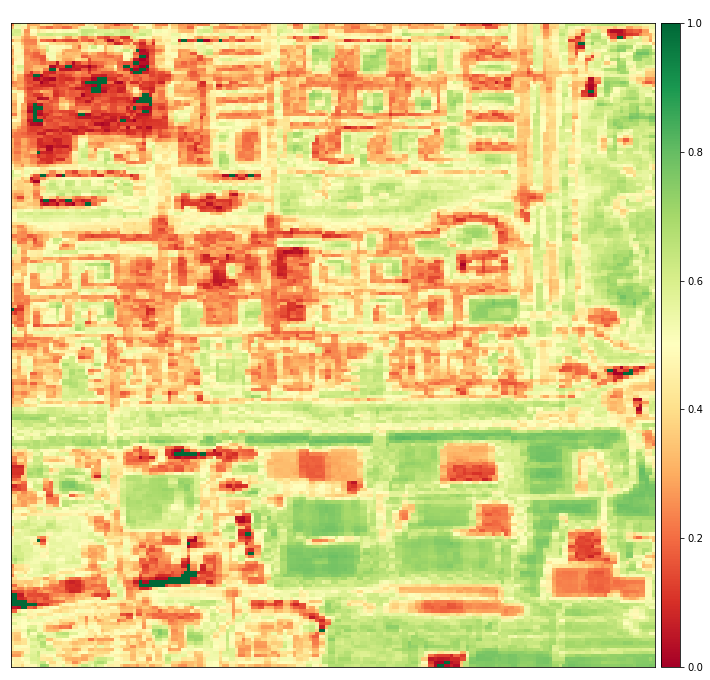

<AxesSubplot:title={'center':' '}>

In [9]:
ndwi = ndwiasi
titles = ' '
ep.plot_bands(ndwi, cmap="RdYlGn", cols=1, title=titles, vmin=0, vmax=1)

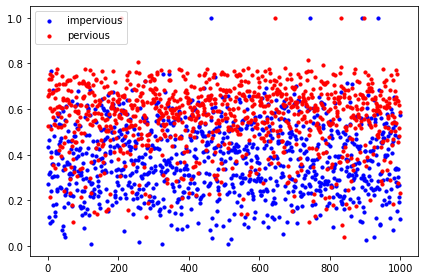

In [13]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

y = ndwi_twitter
x = [x for x in range(len(y))]

ys = ndwi_pervious
xs = [x for x in range(len(ys))]
s = [10]
ax1.scatter(x, y, s, c='b', label='impervious')
ax1.scatter(xs, ys, s, c='r', label='pervious')
plt.legend();
fig.tight_layout()
plt.show()

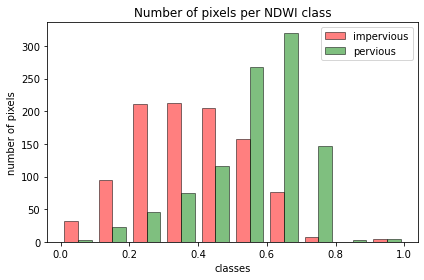

In [17]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

y = ndwi_twitter
x = [x for x in range(len(y))]

ys = ndwi_pervious
xs = [x for x in range(len(ys))]
bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
ax1.hist([ndwi_twitter, ndwi_pervious], bins = bins, 
         alpha=0.5, color = ['red', 'green'], ec = 'black',
         label=['impervious','pervious'])
title = ('Number of pixels per NDWI class')
plt.legend(loc='upper right');
ax1.set_title(title)
ax1.set_xlabel('classes')
ax1.set_ylabel('number of pixels')
fig.tight_layout()

plt.show()